In [3]:
import polars as pl

# --- 1. CHARGER LES "MASTER FILES" (en mode "scan" rapide) ---
try:
    df_sirene = pl.scan_parquet("../Data/processed/sirene_infos.parquet").select(
        "siren", "dateCreationUniteLegale"
    )
    # ▼▼▼ CORRECTION ICI ▼▼▼
    df_bilan = pl.scan_parquet("../Data/processed/sirene_bilan.parquet").select(
        "siren", "AnneeClotureExercice" 
    )
    print("Fichiers 'master' trouvés.")
except Exception as e:
    print(f"ERREUR: Fichiers 'processed' non trouvés. As-tu lancé 'make process'?")
    print(e)

# --- 2. DÉFINIR LA COHORTE (Notre population cible) ---
print("Filtrage: Cohorte 2018 (SIRENE)...")
df_demo_2018 = df_sirene.filter(
    pl.col("dateCreationUniteLegale").dt.year() == 2018
)

# On compte combien d'entreprises ont été créées en 2018
total_cohort_2018 = df_demo_2018.collect().height
print(f"Entreprises créées en 2018 (Cohorte) : {total_cohort_2018}")

# --- 3. DÉFINIR LES BILANS (Nos features expertes) ---
print("Filtrage: Bilans 2019 (INPI)...")
# ▼▼▼ CORRECTION ICI ▼▼▼
df_bilan_2019 = df_bilan.filter(
    pl.col("AnneeClotureExercice") == 2019
)

# --- 4. LE "TEST DE JOINTURE" (L'étape critique) ---
print("Test de la jointure (inner join)...")

# On fait une jointure "inner" pour ne garder QUE les lignes communes
df_overlap = df_demo_2018.join(
    df_bilan_2019, 
    on="siren", 
    how="inner"
)

# On compte le résultat
total_overlap = df_overlap.collect().height

# --- 5. LE VERDICT ---
print("---")
print("--- VERDICT DU DIAGNOSTIC ---")
print(f"Entreprises totales créées en 2018 : {total_cohort_2018}")
print(f"Entreprises de 2018 AVEC un bilan en 2019 : {total_overlap}")

if total_cohort_2018 > 0:
    coverage_percent = (total_overlap / total_cohort_2018) * 100
    print(f"Taux de couverture des données : {coverage_percent:.2f}%")
else:
    print("Aucune entreprise trouvée pour 2018.")

print("---")

if total_overlap < 1000:
    print("ATTENTION: Très peu de données communes. Le modèle risque d'être faible.")
elif total_overlap < 5000:
    print("OK: C'est assez pour un PoC (Proof of Concept), mais c'est peu.")
else:
    print("SUPER: Nous avons des milliers de lignes communes. C'est parfait pour le ML !")

Fichiers 'master' trouvés.
Filtrage: Cohorte 2018 (SIRENE)...
Entreprises créées en 2018 (Cohorte) : 845851
Filtrage: Bilans 2019 (INPI)...
Test de la jointure (inner join)...
---
--- VERDICT DU DIAGNOSTIC ---
Entreprises totales créées en 2018 : 845851
Entreprises de 2018 AVEC un bilan en 2019 : 26361
Taux de couverture des données : 3.12%
---
SUPER: Nous avons des milliers de lignes communes. C'est parfait pour le ML !


In [6]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 1. CHARGER LES "MASTER FILES" ---
PATH_SIRENE = "../Data/processed/sirene_infos.parquet"
PATH_BILAN = "../Data/processed/sirene_bilan.parquet"

if not os.path.exists(PATH_SIRENE) or not os.path.exists(PATH_BILAN):
    print("ERREUR: Fichiers 'processed' non trouvés. Lance 'make process' d'abord.")
else:
    df_sirene = pl.read_parquet(PATH_SIRENE)
    df_bilan = pl.read_parquet(PATH_BILAN)
    print(f"Fichier SIRENE (infos) chargé: {df_sirene.shape}")
    print(f"Fichier INPI (bilans) chargé: {df_bilan.shape}")

# --- 2. DÉFINIR LA COHORTE (Itération 1) ---
print("Filtrage: Cohorte 2018 & Bilans 2019...")

# A. Cohorte 2018 (SIRENE)
# Ce sont nos 845k entreprises
df_demo = df_sirene.filter(
    pl.col("dateCreationUniteLegale").dt.year() == 2018
)

# B. Bilans 2019 (INPI)
df_bilan_2019 = df_bilan.filter(
    pl.col("AnneeClotureExercice") == 2019
)

# --- 3. LE GRAND MARIAGE (LEFT JOIN) ---
# On garde toutes les entreprises de 2018 (gauche)
# On attache les bilans 2019 (droite) s'ils existent
df_final_ml = df_demo.join(
    df_bilan_2019, 
    on="siren", 
    how="left"
)
print(f"Shape après jointure: {df_final_ml.shape}") # Doit être (845851, ...)

# --- 4. CRÉATION DE LA TARGET (Y) ---
print("Création de la Cible (is_failed_in_3y)...")

df_final_ml = df_final_ml.with_columns(
    # Date limite = 3 ans après la création
    # ▼▼▼ CORRECTION ICI ▼▼▼
    (pl.col("dateCreationUniteLegale").dt.offset_by("3y")).alias("date_limite_3_ans")
    # ▲▲▲ CORRECTION ICI ▲▲▲
).with_columns(
    # 1 = Faillite si Fermé AVANT la date limite
    pl.when(
        (pl.col("dateFermeture").is_not_null()) & # dateFermeture n'est pas null
        (pl.col("dateFermeture") < pl.col("date_limite_3_ans"))
    ).then(1)
    .otherwise(0)
    .alias("is_failed_in_3y")
)

# --- 5. NETTOYAGE FINAL (TRÈS IMPORTANT) ---
print("Nettoyage des 'null' (entreprises sans bilan)...")
# Remplir les 'null' des entreprises sans bilan par 0
cols_financieres = [col for col in df_bilan.columns if col not in ['siren', 'DateClotureExercice', 'AnneeClotureExercice']]
df_final_ml = df_final_ml.with_columns(
    pl.col(cols_financieres).fill_null(0)
)

print("---")
print("DATASET ML PRÊT !")
print(f"Shape finale : {df_final_ml.shape}")
print(df_final_ml.head())

Fichier SIRENE (infos) chargé: (28882409, 7)
Fichier INPI (bilans) chargé: (3706645, 21)
Filtrage: Cohorte 2018 & Bilans 2019...
Shape après jointure: (845890, 27)
Création de la Cible (is_failed_in_3y)...
Nettoyage des 'null' (entreprises sans bilan)...
---
DATASET ML PRÊT !
Shape finale : (845890, 29)
shape: (5, 29)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ siren     ┆ dateCreat ┆ dateFerme ┆ categorie ┆ … ┆ ratio_res ┆ ratio_res ┆ date_limi ┆ is_faile │
│ ---       ┆ ionUniteL ┆ ture      ┆ Juridique ┆   ┆ ultat_fin ┆ ultat_exc ┆ te_3_ans  ┆ d_in_3y  │
│ str       ┆ egale     ┆ ---       ┆ UniteLega ┆   ┆ ancier    ┆ eptionnel ┆ ---       ┆ ---      │
│           ┆ ---       ┆ date      ┆ le        ┆   ┆ ---       ┆ ---       ┆ date      ┆ i32      │
│           ┆ date      ┆           ┆ ---       ┆   ┆ f64       ┆ f64       ┆           ┆          │
│           ┆           ┆           ┆ i64       ┆   ┆           ┆         

In [7]:
df_final_ml.describe()

statistic,siren,dateCreationUniteLegale,dateFermeture,categorieJuridiqueUniteLegale,trancheEffectifsUniteLegale,activitePrincipaleUniteLegale,departement,DateClotureExercice,AnneeClotureExercice,HN_RésultatNet,FA_ChiffreAffairesVentes,FB_AchatsMarchandises,CJCK_TotalActifBrut,DL_DettesCourtTerme,DM_DettesLongTerme,DA_TresorerieActive,FJ_ResultatFinancier,FR_ResultatExceptionnel,DF_CapitauxPropres,EG_ImpotsTaxes,ratio_rentabilite_nette,ratio_endettement,ratio_marge_brute,ratio_capitaux_propres,ratio_tresorerie,ratio_resultat_financier,ratio_resultat_exceptionnel,date_limite_3_ans,is_failed_in_3y
str,str,str,str,f64,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64
"""count""","""845890""","""845890""","""27598""",845890.0,"""845890""","""845890""","""836126""","""26361""",26361.0,845890.0,845890.0,845890.0,845890.0,845890.0,845890.0,845890.0,845890.0,845890.0,845890.0,845890.0,845890.0,845890.0,845890.0,845890.0,845890.0,845890.0,845890.0,"""845890""",845890.0
"""null_count""","""0""","""0""","""818292""",0.0,"""0""","""0""","""9764""","""819529""",819529.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0
"""mean""",null,"""2018-06-19 15:04:46.275520""","""2021-09-18 01:42:16.096818""",3200.040626,null,null,null,"""2019-11-16 13:55:50.085353""",2019.0,-4255.514489,14808.383796,904.442341,35541.086275,53081.551359,33.088701,39189.520328,26643.464651,49550.850438,13.134286,13835.143672,-6.1278e8,3.3726e9,-3.8918e8,0.000016,3.2795e9,9.4209e9,3.1257e10,"""2021-06-19 15:04:46.275520""",0.014031
"""std""",null,null,null,2668.579111,null,null,null,null,0.0,2.0561e6,4.0070e6,357462.63823,3.7883e6,5.9329e6,21304.143515,4.4276e6,4.2435e6,5.7295e6,6093.305522,868642.657272,6.1648e11,2.3507e12,3.1477e11,0.006407,2.3489e12,1.2734e12,4.0063e12,null,0.11762
"""min""","""130023385""","""2018-01-01""","""2017-12-31""",1000.0,"""00""","""00.00Z""","""01""","""2019-01-24""",2019.0,-1.3927e9,-573072.0,-183891.0,-4841.0,-1.3911e9,0.0,-6.81348e6,-573072.0,-1.366158e6,0.0,-1.616154e6,-5.0029e14,-3.0060e12,-2.8905e14,0.0,-41.914076,-4.5240e10,-1.3662e12,"""2021-01-01""",0.0
"""25%""",null,"""2018-03-15""","""2020-05-30""",1000.0,null,null,null,"""2019-09-30""",2019.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""2021-03-15""",0.0
"""50%""",null,"""2018-06-18""","""2021-11-03""",1000.0,null,null,null,"""2019-12-31""",2019.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""2021-06-18""",0.0
"""75%""",null,"""2018-09-28""","""2023-02-05""",5710.0,null,null,null,"""2019-12-31""",2019.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""2021-09-28""",0.0
"""max""","""993394725""","""2018-12-31""","""2025-10-31""",9970.0,"""NN""","""99.00Z""","""[N""","""2019-12-31""",2019.0,1.22840821e8,2.1475e9,2.89050572e8,2.1475e9,2.1475e9,1.8886746e7,2.1475e9,2.1475e9,2.1475e9,5e6,4.58706413e8,1.2284e14,2.1475e15,2.0,5.503931,2.1475e15,9.8598e14,2.1475e15,"""2021-12-31""",1.0


Analyse de la Cible (Y) :
shape: (2, 2)
┌─────────────────┬────────┐
│ is_failed_in_3y ┆ count  │
│ ---             ┆ ---    │
│ i32             ┆ u32    │
╞═════════════════╪════════╡
│ 0               ┆ 834021 │
│ 1               ┆ 11869  │
└─────────────────┴────────┘


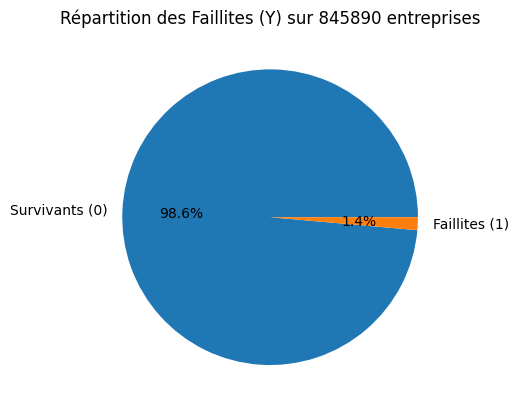


Analyse 'Démo' : Faillite par Catégorie Juridique


/var/folders/sp/97__4mlj3nbc2fssvlgn3_nh0000gn/T/ipykernel_23798/1991879894.py:23: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  df_plot_demo = df_final_ml.filter(pl.col('categorieJuridiqueUniteLegale').is_in(top_6_cat))


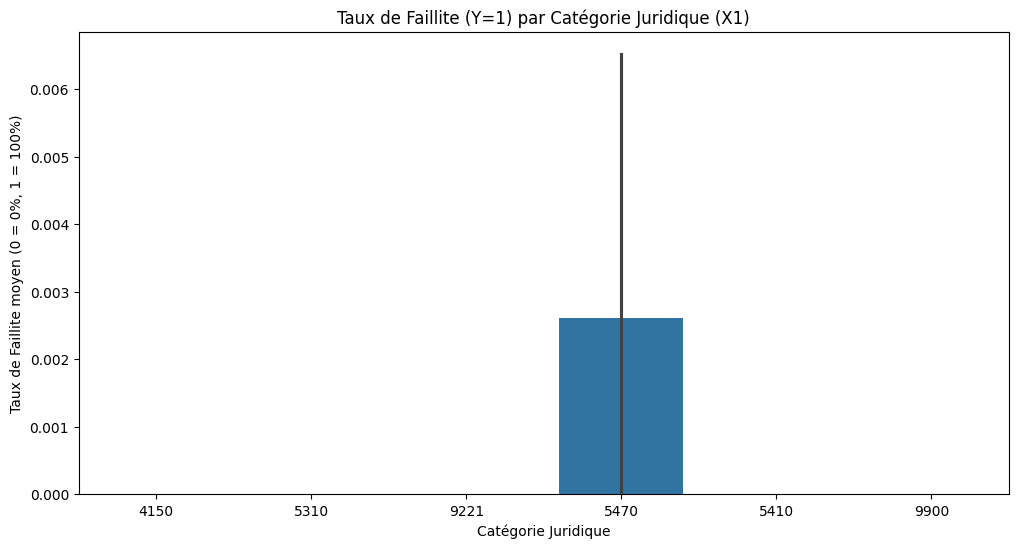


Analyse 'Experte' : Rentabilité vs Faillite (sur 2862 entreprises)


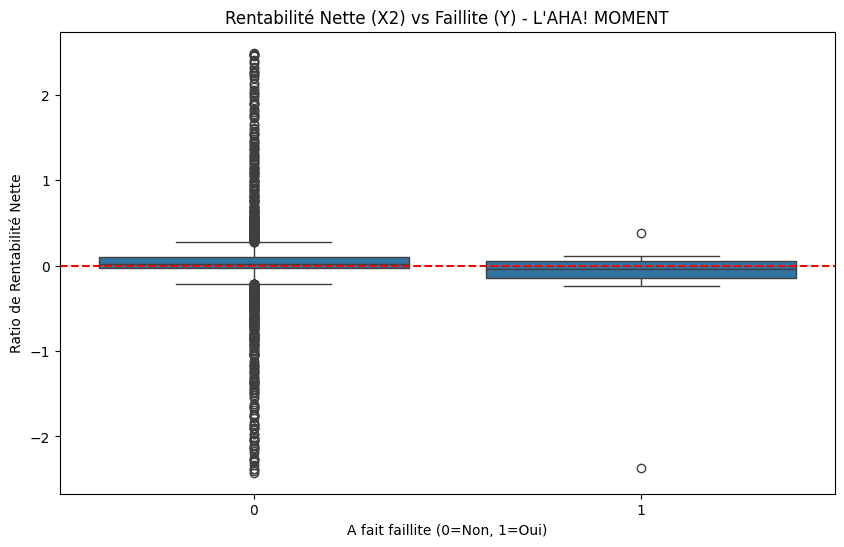

In [8]:
# --- 1. Analyse de la CIBLE (Le Déséquilibre) ---
print("Analyse de la Cible (Y) :")

# On compte le nombre de 0 (Survivants) et de 1 (Faillites)
target_counts = df_final_ml.get_column("is_failed_in_3y").value_counts(sort=True)
print(target_counts)

# (Convertis en pandas pour le plot)
target_counts_pd = target_counts.to_pandas().set_index('is_failed_in_3y')
target_counts_pd.plot(kind='pie', y='count', autopct='%1.1f%%', legend=False,
                      labels=['Survivants (0)', 'Faillites (1)'])
plt.title(f"Répartition des Faillites (Y) sur {df_final_ml.shape[0]} entreprises")
plt.ylabel("") # Enlève le label 'count' inutile
plt.show()


# --- 2. EDA "Démo" (Le Châssis) ---
# On veut voir le % de faillite par catégorie juridique
print("\nAnalyse 'Démo' : Faillite par Catégorie Juridique")

# (On prend les 6 catégories les plus courantes pour un plot lisible)
top_6_cat = df_final_ml.get_column('categorieJuridiqueUniteLegale').value_counts().head(6).get_column('categorieJuridiqueUniteLegale')
df_plot_demo = df_final_ml.filter(pl.col('categorieJuridiqueUniteLegale').is_in(top_6_cat))

# Plot
plt.figure(figsize=(12, 6))
# On utilise to_pandas() car seaborn fonctionne mieux avec pandas
sns.barplot(data=df_plot_demo.to_pandas(), 
            x="categorieJuridiqueUniteLegale", 
            y="is_failed_in_3y", 
            order=top_6_cat)
plt.title("Taux de Faillite (Y=1) par Catégorie Juridique (X1)")
plt.xlabel("Catégorie Juridique")
plt.ylabel("Taux de Faillite moyen (0 = 0%, 1 = 100%)")
plt.show()


# --- 3. EDA "Experte" (Le Moteur - L'Aha! Moment) ---
# On ne prend QUE les 26k entreprises qui ont un bilan
# Notre filtre : celles où la rentabilité n'est pas 0 (le 'fill_null')
df_plot_finance = df_final_ml.filter(
    pl.col("ratio_rentabilite_nette") != 0 
)

# On filtre les outliers fous pour le plot (sinon on ne voit rien)
df_plot_finance_filtered = df_plot_finance.filter(
    pl.col("ratio_rentabilite_nette").is_between(-2.5, 2.5) # Filtre -250% à +250%
)

print(f"\nAnalyse 'Experte' : Rentabilité vs Faillite (sur {df_plot_finance_filtered.shape[0]} entreprises)")
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_plot_finance_filtered.to_pandas(), 
            x="is_failed_in_3y", 
            y="ratio_rentabilite_nette")
plt.title("Rentabilité Nette (X2) vs Faillite (Y) - L'AHA! MOMENT")
plt.xlabel("A fait faillite (0=Non, 1=Oui)")
plt.ylabel("Ratio de Rentabilité Nette")
plt.axhline(0, color='red', linestyle='--') # Ajoute une ligne à 0
plt.show()

Utiliser ML FLOW 